In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['LEG']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,MI,PC-000231,Retailer,"Lake Effect Group, LLC",True,Active,MI-01483,Provisioning Center - License,1e33498d-98f8-4b63-9260-4342ef5963a2,94fc2469-a18d-4cfd-a826-11b997ec18af
1,MI,PC-000335,Retailer,DOJA,True,Active,MI-00616,Provisioning Center - License,1e33498d-98f8-4b63-9260-4342ef5963a2,d86ea51c-6e3e-4979-b3d1-895abf38ece7
2,MI,PR-000130,Manufacturer,Black Market,True,Active,MI-00331,Processor - License,1e33498d-98f8-4b63-9260-4342ef5963a2,None
3,MI,AU-P-000163,Manufacturer,Black Market,True,Active,MI-00331,Marihuana Processor - License,1e33498d-98f8-4b63-9260-4342ef5963a2,None
4,MI,AU-R-000260,Retailer,"LAKE EFFECT GROUP, LLC",True,Active,MI-01483,Marihuana Retailer - License,1e33498d-98f8-4b63-9260-4342ef5963a2,94fc2469-a18d-4cfd-a826-11b997ec18af
5,MI,AU-R-000261,Retailer,DOJA,True,Active,MI-00616,Marihuana Retailer - License,1e33498d-98f8-4b63-9260-4342ef5963a2,d86ea51c-6e3e-4979-b3d1-895abf38ece7


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['AU-P-000163', 'PR-000130', 'PC-000231', 'AU-R-000260',
       'PC-000335', 'AU-R-000261'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license AU-P-000163...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-16

Verifying download summaries for license PR-000130...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-16

Verifying download summaries for license PC-000231...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-16

Verifying download summaries for license AU-R-000260...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-16

Verifying download summaries for license PC-000335...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-16

Verifying download summaries for license AU-R-000261...
Earliest download summary: 2021-01-01
Latest download summary: 2022-06-16

[SUCCESS] All download summaries look good!


In [10]:
bad_download_history

defaultdict(list, {})

## Choose license numbers

In [11]:
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['PC-000231', 'PC-000335', 'AU-R-000260', 'AU-R-000261']

In [12]:
if COMPANY_IDENTIFIER == ['GRG']:
    license_numbers = ['C10-0000169-LIC']
elif COMPANY_IDENTIFIER == ['CSC']:
    license_numbers = ['C10-0000670-LIC']
license_numbers

['PC-000231', 'PC-000335', 'AU-R-000260', 'AU-R-000261']

# License check

In [13]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,MI,PC-000231,Retailer,"Lake Effect Group, LLC",True,Active,MI-01483,Provisioning Center - License,1e33498d-98f8-4b63-9260-4342ef5963a2,94fc2469-a18d-4cfd-a826-11b997ec18af
1,MI,PC-000335,Retailer,DOJA,True,Active,MI-00616,Provisioning Center - License,1e33498d-98f8-4b63-9260-4342ef5963a2,d86ea51c-6e3e-4979-b3d1-895abf38ece7
2,MI,PR-000130,Manufacturer,Black Market,True,Active,MI-00331,Processor - License,1e33498d-98f8-4b63-9260-4342ef5963a2,None
3,MI,AU-P-000163,Manufacturer,Black Market,True,Active,MI-00331,Marihuana Processor - License,1e33498d-98f8-4b63-9260-4342ef5963a2,None
4,MI,AU-R-000260,Retailer,"LAKE EFFECT GROUP, LLC",True,Active,MI-01483,Marihuana Retailer - License,1e33498d-98f8-4b63-9260-4342ef5963a2,94fc2469-a18d-4cfd-a826-11b997ec18af
5,MI,AU-R-000261,Retailer,DOJA,True,Active,MI-00616,Marihuana Retailer - License,1e33498d-98f8-4b63-9260-4342ef5963a2,d86ea51c-6e3e-4979-b3d1-895abf38ece7


In [14]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'MI'

In [15]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,PC-000231,Retailer,True,Active,MI,YES
1,PC-000335,Retailer,True,Active,MI,YES
2,AU-R-000260,Retailer,True,Active,MI,YES
3,AU-R-000261,Retailer,True,Active,MI,YES


## Pull data

In [16]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [17]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['AU-R-000261', 'AU-R-000260', 'PC-000231', 'PC-000335'],
      dtype=object)

In [18]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['AU-R-000261', 'PC-000335', 'PC-000231', 'AU-R-000260'],
      dtype=object)

In [19]:
company_inventory_packages_dataframe['license_number'].unique()

array(['AU-R-000260', 'AU-R-000261', 'PC-000231', 'PC-000335'],
      dtype=object)

# pull repayment data (if any)

In [20]:
# fetch repayment history query
company_repayment_query = create_queries.create_company_repayment_history_query(COMPANY_IDENTIFIER)
company_repayment_data = pd.read_sql_query(company_repayment_query, engine)

In [21]:
company_repayment_data

,company_id,identifier,loan_id,loan_amount,outstanding_principal_balance,adjusted_maturity_date,last_settlement_date,total_paid,days_late_temp,days_late


## Unknown transfer packages

In [22]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [23]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(24387, 31)

In [24]:
company_incoming_transfer_packages_dataframe.shape

(26249, 31)

In [25]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


93.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [26]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [27]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [28]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['AU-R-000261', 'PC-000335', 'PC-000231', 'AU-R-000260'],
      dtype=object)

## Trxns missing incoming transfer packages

In [29]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 657377 (46.56363376215308%)
# transactions total: 1411782


In [30]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2020-01     4967
2020-02     4112
2020-08      675
2020-09     3282
2020-10     4821
2020-11     4832
2020-12     6066
2021-01    13157
2021-02    10355
2021-03    10983
2021-04    11816
2021-05    12484
2021-06    16987
2021-07    17107
2021-08    26083
2021-09    27551
2021-10    27698
2021-11    28379
2021-12    31847
2022-01    27034
2022-02    25621
2022-03    24440
2022-04    23497
2022-05    21001
2022-06    10521
dtype: int64

## Receipts missing metrc_sales_transactions

In [31]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [32]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 583219


In [33]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

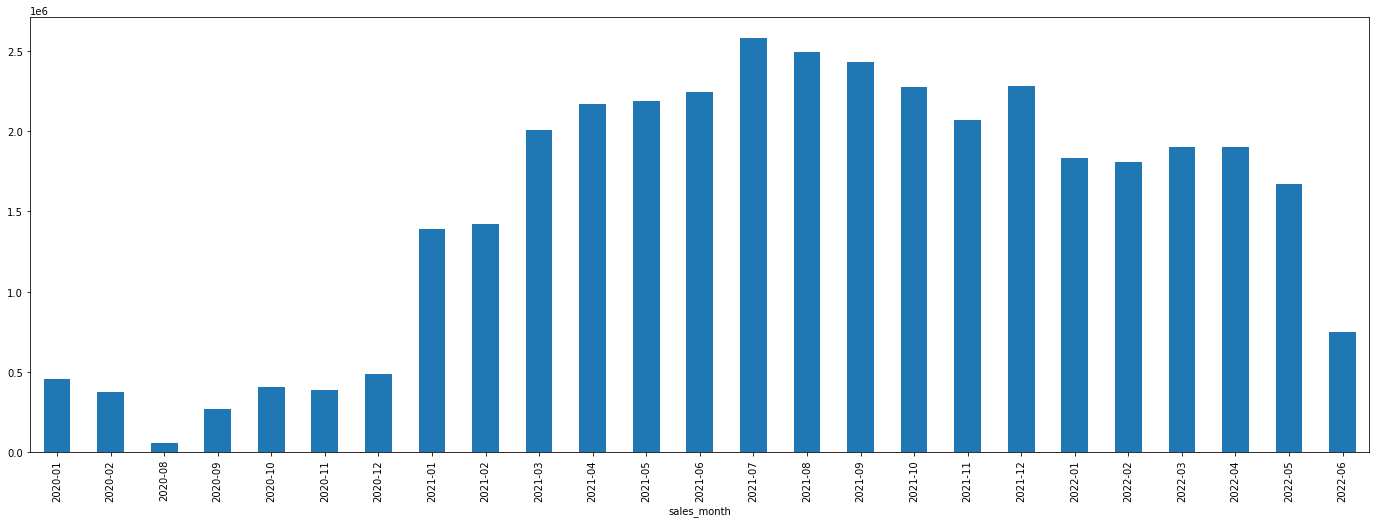

In [34]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# Vendor churn

In [35]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-05-01'
VC_MONTH_LIST = ['2022-02-01','2022-03-01','2022-04-01','2022-05-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [36]:
license_numbers

['PC-000231', 'PC-000335', 'AU-R-000260', 'AU-R-000261']

In [37]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [38]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


In [39]:
churn_short

,year_month,%_inactive
year_month,,
2020-01-01,2020-01-01,0.000000
2020-02-01,2020-02-01,0.000000
2020-03-01,2020-03-01,0.000000
2020-04-01,2020-04-01,0.000000
2020-05-01,2020-05-01,0.000000
2020-06-01,2020-06-01,0.000000
2020-07-01,2020-07-01,0.000000
2020-08-01,2020-08-01,0.000000
2020-09-01,2020-09-01,0.000000


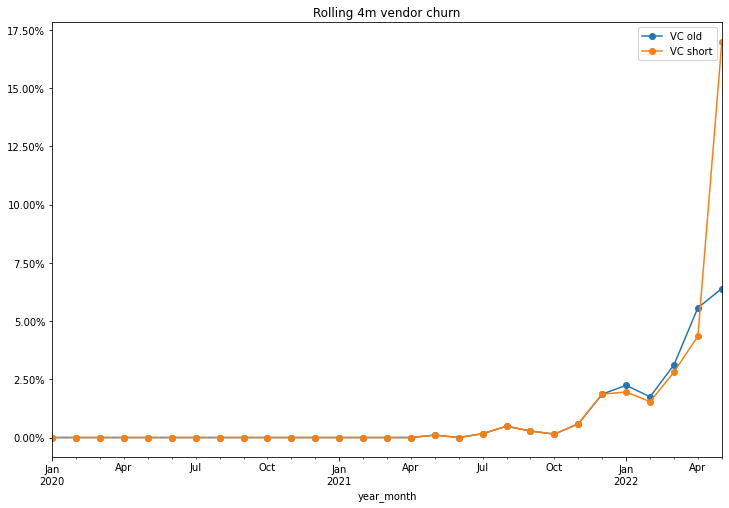

In [40]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [41]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 375025.0 from package ID: 2418086
min per unit incoming: 1.576789656259855e-06 from package ID: 3428980



In [42]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,2418086,375025.000000
1,2418085,250025.000000
2,3086231,6270.000000
3,4061407,6006.000000
4,2198492,5841.333333
5,4390955,3600.000000
6,3455455,3570.000000
7,3455461,3570.000000
8,3455553,3570.000000
9,3332509,3570.000000


In [43]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
24677,3429332,0.000011
24678,3104243,0.000004
24679,3429501,0.000003
24680,3429360,0.000002
24681,3428980,0.000002


In [44]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] > 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming
21160,INCOMING_FROM_VENDOR,AU-R-000261,0000611856,2021-05-04,2021-05-05 17:33:20+00:00,Wholesale,AU-P-000099,Exclusive Brands LLC,AU-R-000261,DOJA,Wholesale,Wholesale,2418085,1A405030000507B000033347,transfer,1A405030000507B000009721,"2020-10-16_GMO_Harvest Room, 2020-10-17_GMO_Ha...",Accepted,False,False,Vape Cart,Terpene Tank Exclusive OG 1g Maxx,passed,12001200.0,48.0,Each,12001200.0,48.0,Each,1.0,Grams,250025.0
21194,INCOMING_FROM_VENDOR,AU-R-000261,0000611856,2021-05-04,2021-05-05 17:33:20+00:00,Wholesale,AU-P-000099,Exclusive Brands LLC,AU-R-000261,DOJA,Wholesale,Wholesale,2418086,1A405030000507B000033348,transfer,1A405030000507B000009715,"2020-10-16_GMO_Harvest Room, 2020-10-17_GMO_Ha...",Accepted,False,False,Vape Cart,Terpene Tank Jack 1g Maxx,passed,18001200.0,48.0,Each,18001200.0,48.0,Each,1.0,Grams,375025.0


# COGS analysis

In [45]:
df_in = company_incoming_transfer_packages_dataframe
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [46]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [47]:
df_summary_simp_uom,df_cogs_average_product_uom = client_surveillance_jupyter.cogs_analysis_uom(df_in,df_sales,'monthly',company_state)


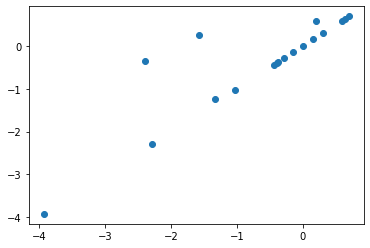

In [55]:
plt.scatter(df_summary_simp['margin_%'] ,df_summary_simp_uom['margin_%'] )

In [48]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,1389908.50,2825818.95,-1435910.45,-1.03,23687,9277,14410,0.56,42435,1598394.78,3588790.07,-1990395.29,-1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.03,NaN,NaN,NaN,NaN
2021-02,2021-02,1422408.14,579823.99,842584.15,0.59,30085,3244,26841,0.66,45391,1635769.36,736376.47,899392.89,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59,NaN,NaN,NaN,0.02
2021-03,2021-03,2007705.00,1626942.90,380762.10,0.19,45630,2977,42653,0.74,61628,2308860.75,2066217.49,242643.26,0.11,-0.08,NaN,NaN,5032585.85,-0.20,NaN,NaN,0.19,-0.08,NaN,NaN,0.41
2021-04,2021-04,2169928.37,5597853.09,-3427924.72,-1.58,54331,2734,51597,0.75,72280,2495417.63,7109273.42,-4613855.80,-1.85,-0.27,NaN,NaN,7804619.99,-0.40,NaN,NaN,-1.58,-0.27,NaN,NaN,0.08
2021-05,2021-05,2185674.09,7441513.57,-5255839.48,-2.40,57023,3581,53442,0.76,74852,2513525.20,9450722.23,-6937197.03,-2.76,-1.26,NaN,NaN,14666309.56,-1.50,NaN,NaN,-2.40,-1.26,NaN,NaN,0.01
2021-06,2021-06,2242260.89,5215665.11,-2973404.22,-1.33,61957,11948,50009,0.80,77922,2578600.02,6623894.69,-4045294.66,-1.57,-1.77,-0.93,NaN,18255031.77,-2.06,-1.13,NaN,-1.33,-1.77,-0.93,NaN,0.03
2021-07,2021-07,2580179.43,12703947.08,-10123767.65,-3.92,71755,7635,64120,0.77,92634,2967206.34,16134012.79,-13166806.44,-4.44,-2.55,-1.41,NaN,25361125.75,-2.92,-1.66,NaN,-3.92,-2.55,-1.41,NaN,0.15
2021-08,2021-08,2495666.96,3436912.79,-941245.83,-0.38,53329,3551,49778,0.61,87837,2870017.00,4364879.24,-1494862.24,-0.52,-1.88,-1.57,NaN,21356524.97,-2.18,-1.84,NaN,-0.38,-1.88,-1.57,NaN,-0.03
2021-09,2021-09,2432801.53,3510046.43,-1077244.90,-0.44,51135,5492,45643,0.60,85143,2797721.76,4457758.97,-1660037.21,-0.59,-1.58,-1.68,-1.15,19650906.30,-1.85,-1.95,-1.37,-0.44,-1.58,-1.68,-1.15,-0.03


In [49]:
df_summary_simp_uom

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,1389908.50,2825818.95,-1435910.45,-1.03,23687,9277,14410,0.56,42435,1598394.78,3588790.07,-1990395.29,-1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.03,NaN,NaN,NaN,NaN
2021-02,2021-02,1422408.14,579823.99,842584.15,0.59,30085,3244,26841,0.66,45391,1635769.36,736376.47,899392.89,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59,NaN,NaN,NaN,0.02
2021-03,2021-03,2007705.00,824575.23,1183129.77,0.59,45630,2977,42653,0.74,61628,2308860.75,1047210.54,1261650.21,0.55,0.05,NaN,NaN,4230218.18,-0.05,NaN,NaN,0.59,0.05,NaN,NaN,0.41
2021-04,2021-04,2169928.37,1632471.78,537456.59,0.25,54331,2734,51597,0.75,72280,2495417.63,2073239.16,422178.47,0.17,0.48,NaN,NaN,3036871.00,0.42,NaN,NaN,0.25,0.48,NaN,NaN,0.08
2021-05,2021-05,2185674.09,2966742.76,-781068.67,-0.36,57023,3581,53442,0.76,74852,2513525.20,3767763.30,-1254238.10,-0.50,0.16,NaN,NaN,5423789.76,0.07,NaN,NaN,-0.36,0.16,NaN,NaN,0.01
2021-06,2021-06,2242260.89,5028562.51,-2786301.62,-1.24,61957,11948,50009,0.80,77922,2578600.02,6386274.39,-3807674.36,-1.48,-0.45,-0.20,NaN,9627777.04,-0.60,-0.33,NaN,-1.24,-0.45,-0.20,NaN,0.03
2021-07,2021-07,2580179.43,12700554.57,-10120375.14,-3.92,71755,7635,64120,0.77,92634,2967206.34,16129704.31,-13162497.96,-4.44,-1.84,-0.68,NaN,20695859.84,-2.14,-0.86,NaN,-3.92,-1.84,-0.68,NaN,0.15
2021-08,2021-08,2495666.96,3436912.79,-941245.83,-0.38,53329,3551,49778,0.61,87837,2870017.00,4364879.24,-1494862.24,-0.52,-1.85,-0.84,NaN,21166029.87,-2.14,-1.04,NaN,-0.38,-1.85,-0.84,NaN,-0.03
2021-09,2021-09,2432801.53,3510046.43,-1077244.90,-0.44,51135,5492,45643,0.60,85143,2797721.76,4457758.97,-1660037.21,-0.59,-1.58,-1.02,-0.66,19647513.79,-1.85,-1.23,-0.83,-0.44,-1.58,-1.02,-0.66,-0.03


# Revenue change vs state

In [58]:
if COMPANY_IDENTIFIER == ['NECC']:
    a = client_surveillance_jupyter.calculate_quarterly_sum_gmv_ma_short(df_summary_simp)
    a

In [59]:
if COMPANY_IDENTIFIER == ['NECC']:
    round(a.dropna()['total'].sum(),2)

In [60]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

24.3

In [61]:
a

,revenue_change,sum_gmv_change_mi,weight,variance,points,total
date,,,,,,
2021-04,0.08,-0.01,0.04,0.09,10.0,0.4
2021-05,0.01,-0.10,0.12,0.11,10.0,1.2
2021-06,0.03,-0.05,0.20,0.08,10.0,2.0
2021-07,0.15,0.08,0.28,0.07,10.0,2.8
2021-08,-0.03,-0.11,0.36,0.08,10.0,3.6
2021-09,-0.03,-0.06,0.44,0.03,5.0,2.2
2021-10,-0.07,-0.03,0.52,-0.04,0.0,0.0
2021-11,-0.09,-0.10,0.60,0.01,5.0,3.0
2021-12,0.10,0.04,0.68,0.06,10.0,6.8


# Inventory

In [62]:
today = date.today()
today

datetime.date(2022, 6, 16)

In [63]:
COMPANY_IDENTIFIER

['LEG']

In [64]:
license_numbers

['PC-000231', 'PC-000335', 'AU-R-000260', 'AU-R-000261']

In [65]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory,license_numbers,today)

In [66]:
df_inventory_license

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-06-16,5840308.71,7417192.06,14925,18000,0.83,"[PC-000231, PC-000335, AU-R-000260, AU-R-000261]",DOJA


In [67]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [68]:
df_inventory_license_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-06-16,6854229.57,14901,18000,0.83,"[PC-000231, PC-000335, AU-R-000260, AU-R-000261]",DOJA


In [69]:
df_inventory_fresh,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today)

In [70]:
df_inventory_fresh

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-06-16,661172.99,839689.7,2795,4074,0.69,"[PC-000231, PC-000335, AU-R-000260, AU-R-000261]",DOJA


# Quantity based inventory TO

In [71]:
df_inventory.head()

,license_number,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,AU-R-000260,6609195,1A405030000C865000002780,active,2022-06-15,2022-06-15 15:54:57+00:00,Product,Select 510 - Hippie Chicken - 1g,Vape Cart,40.0,Each,2389067,Concentrate,,05.24.2022.SelectElite1gHippieChicken,"9 Pound Hammer_102821_709_OD, Acapulco Gold_10...",False,False,False,None,None
1,AU-R-000260,6610635,1A405030000C865000002783,active,2022-06-15,2022-06-15 16:12:56+00:00,Product,Select Essentials 510 - Tropic Thunder - 1g,Vape Cart,40.0,Each,2389901,Concentrate,,05.24.2022.SelectEssentials1gTropicThunder,Trim-9/15/21,False,False,False,None,None
2,AU-R-000260,6609128,1A405030000C865000002776,active,2022-06-15,2022-06-15 15:27:10+00:00,Product,Select 510 - AK-47 - 1g,Vape Cart,40.0,Each,1134014,Concentrate,,05.19.2022.SelectElite1gAK47,"Flower Room 1 - ACC x AJ (Oct26), Flower Room ...",False,False,False,None,None
3,AU-R-000260,6609140,1A405030000C865000002777,active,2022-06-15,2022-06-15 15:35:04+00:00,Product,Select 510 - Northern Lights - 1g,Vape Cart,40.0,Each,1601925,Concentrate,,05.09.2022.SelectElite1gNorthernLights,"Blue Dream JAN10 307, Blue Dream JAN17 305, Ge...",False,False,False,None,None
4,AU-R-000260,6609958,1A405030000C865000002782,active,2022-06-15,2022-06-15 16:08:14+00:00,Product,Select Essentials 510 - Berry Runtz - 1g,Vape Cart,40.0,Each,2389075,Concentrate,,04_20_2022_SelectEssentials_BerryRuntz,"2020-05-14_Mandarin Sunset_Room 1, 2020-07-28_...",False,False,False,None,None


In [72]:
inventory_q = df_inventory[['package_id','unit_of_measure','quantity']].groupby(['package_id','unit_of_measure']).sum()



In [73]:
inventory_q = inventory_q.reset_index()
inventory_q

,package_id,unit_of_measure,quantity
0,1001349,Each,2.00
1,1014406,Each,0.00
2,1014417,Each,-1.00
3,1017135,Each,0.00
4,1039161,Each,1.00
...,...,...,...
17995,950303,Each,1.00
17996,961713,Each,1.00
17997,982466,Each,0.00
17998,982468,Each,-4.00


In [75]:
df_sales_3m = df_sales[df_sales['sales_month'] >= '2022-03']

In [76]:
sales_q = df_sales_3m[['tx_package_id','tx_unit_of_measure','tx_quantity_sold']].groupby(['tx_package_id','tx_unit_of_measure']).sum()
sales_q = sales_q.reset_index()


In [78]:
j = inventory_q.merge(sales_q,how = 'left',left_on = ['package_id','unit_of_measure'],right_on = ['tx_package_id','tx_unit_of_measure'])



In [79]:
j['to'] = j['tx_quantity_sold'] / j['quantity'] * 4

In [80]:
j[j['to'] >= 50]

,package_id,unit_of_measure,quantity,tx_package_id,tx_unit_of_measure,tx_quantity_sold,to
6,1052244,Each,0.00,1052244,Each,1.00,inf
37,1161317,Each,0.00,1161317,Each,1.00,inf
201,1420286,Each,0.00,1420286,Each,1.00,inf
546,1652537,Each,0.00,1652537,Each,1.00,inf
548,1657690,Each,0.00,1657690,Each,2.00,inf
...,...,...,...,...,...,...,...
17788,6434603,Each,1.00,6434603,Each,154.00,616.000000
17790,6439141,Grams,8.77,6439141,Grams,4376.47,1996.109464
17803,6447192,Each,8.00,6447192,Each,145.00,72.500000
17844,6499790,Grams,15.52,6499790,Grams,2445.94,630.396907


In [81]:
j['to'].describe()

count    6.568000e+03
mean              inf
std               NaN
min     -3.202000e+04
25%      4.666667e+00
50%      5.600000e+01
75%               NaN
max               inf
Name: to, dtype: float64

# Repayment score

In [82]:
company_repayment_data

,company_id,identifier,loan_id,loan_amount,outstanding_principal_balance,adjusted_maturity_date,last_settlement_date,total_paid,days_late_temp,days_late


In [83]:
company_repayment_data_due = company_repayment_data[company_repayment_data['adjusted_maturity_date'] < today]

In [84]:
company_repayment_data_due


,company_id,identifier,loan_id,loan_amount,outstanding_principal_balance,adjusted_maturity_date,last_settlement_date,total_paid,days_late_temp,days_late


In [85]:
company_repayment_data_due['weight'] = company_repayment_data_due['loan_amount'] / sum(company_repayment_data_due['loan_amount'])

In [86]:
len(company_repayment_data_due)

0

In [94]:
if len(company_repayment_data_due) == 0:
    weighted_dpd = numpy.nan
else:
    weighted_dpd = sum(company_repayment_data_due['days_late'] * company_repayment_data_due['weight'])

    

In [95]:
weighted_dpd

nan

In [96]:
repayment_score = client_surveillance_jupyter.get_short_repayment_score(weighted_dpd)
repayment_score

# Create Template: updated

In [ ]:
current_month = '2022-05'
full_score = 45

In [ ]:
license_numbers

In [ ]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,df_inventory_fresh,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



In [ ]:
template_new_

# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



In [ ]:
# multiple licenses
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today)  +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    